## ✅Préstamos Emitidos por Club

### 1. 📥 Carga del Dataset

In [55]:
import pandas as pd

# Cargar el dataset desde archivo CSV descargado desde Kaggle
df = pd.read_csv("lc_2016_2017.csv", low_memory=False)
df = df.sample(n=20000, random_state=42)
# Reiniciar los índices (opcional pero recomendable)
df = df.reset_index(drop=True)
df.head()


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,96780482,NaN,10000,10000,10000.0,36 months,5.32,301.15,A,A1,...,0.0,NaN,0.0,0.0,3168.0,29.0,28400.0,0.0,0.0,0.0
1,114167486,NaN,6000,6000,6000.0,36 months,10.91,196.18,B,B4,...,42686.0,78.0,2.0,2.0,5054.0,70.0,42500.0,2.0,2.0,2.0
2,115400180,NaN,2800,2800,2800.0,36 months,7.07,86.55,A,A2,...,90111.0,75.0,1.0,2.0,19694.0,69.0,73100.0,1.0,5.0,2.0
3,85544941,NaN,11200,11200,10950.0,36 months,10.99,366.63,B,B4,...,43341.0,78.0,0.0,2.0,2881.0,77.0,11500.0,1.0,2.0,4.0
4,111007274,NaN,2800,2800,2800.0,36 months,15.05,97.14,C,C4,...,0.0,NaN,16.0,17.0,2611.0,7.0,51900.0,0.0,0.0,5.0


### 2. 🧹 Limpieza de Datos

In [56]:
# Eliminar columnas con más del 50% de valores nulos
df = df.loc[:, df.isnull().mean() < 0.5]

# Eliminar columnas irrelevantes (IDs, nombres, fechas, etc.)
irrelevantes = ['id', 'member_id', 'url', 'desc', 'title', 'zip_code', 'emp_title']
df = df.drop(columns=[col for col in irrelevantes if col in df.columns])

# Eliminar filas con nulos
df = df.dropna()

# Codificar variables categóricas
df = pd.get_dummies(df, drop_first=True)


### 3. 📏 Escalado de Datos

In [57]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)


### 4. 🔢 Elegir Número de Clusters (Método del Codo y Silhouette Score)

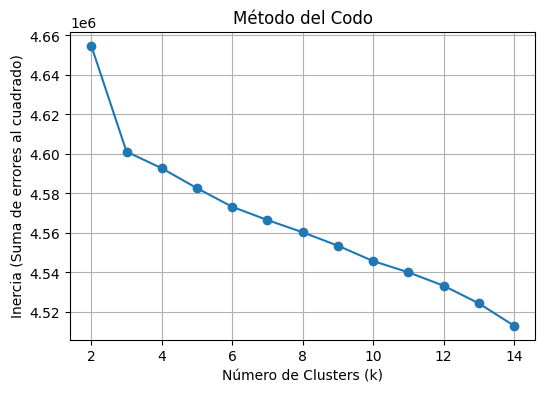

In [58]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def plot_elbow_method(scaled_data):
    inertia = []
    k_values = range(2, 15)
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_data)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(6, 4))
    plt.plot(k_values, inertia, marker='o')
    plt.xlabel("Número de Clusters (k)")
    plt.ylabel("Inercia (Suma de errores al cuadrado)")
    plt.title("Método del Codo")
    plt.grid(True)
    plt.show()
plot_elbow_method(scaled_data)

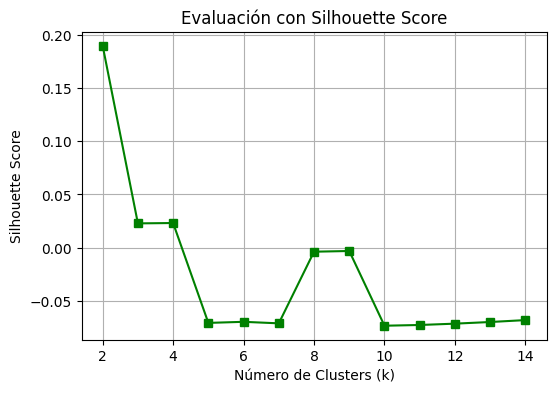

In [59]:
from sklearn.metrics import silhouette_score

def plot_silhouette_scores(scaled_data):
    silhouette_scores = []
    k_values = range(2, 15)
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(scaled_data)
        score = silhouette_score(scaled_data, labels)
        silhouette_scores.append(score)
    
    plt.figure(figsize=(6, 4))
    plt.plot(k_values, silhouette_scores, marker='s', color='green')
    plt.xlabel("Número de Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("Evaluación con Silhouette Score")
    plt.grid(True)
    plt.show()
plot_silhouette_scores(scaled_data)


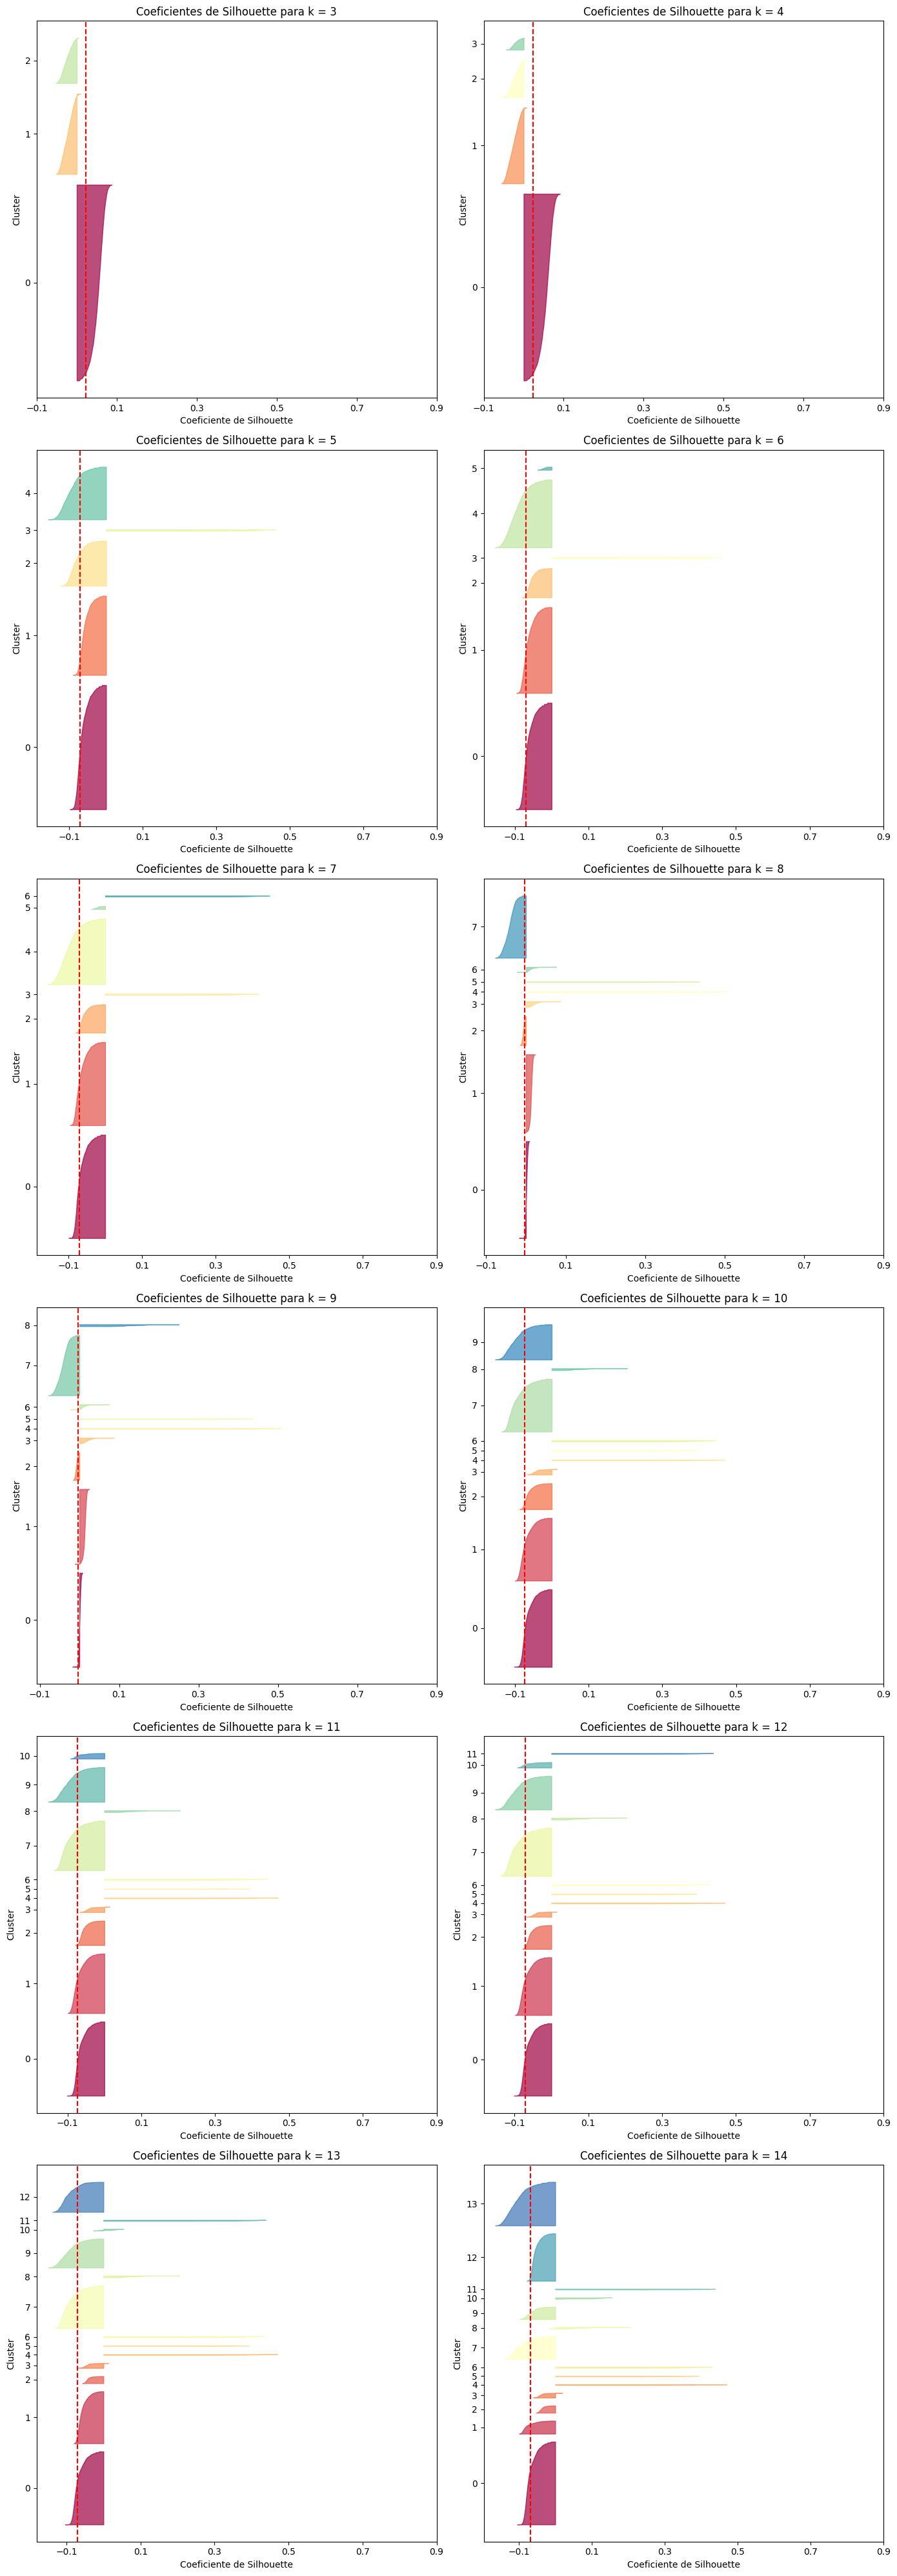

In [60]:
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn.cluster import KMeans

# Rango de k de 2 a 14
k_values = range(2, 15)
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(scaled_data) for k in k_values]
silhouette_scores = [silhouette_score(scaled_data, model.labels_) for model in kmeans_per_k]

# Graficar coeficientes individuales para k = 3 a 14 (en 2 columnas)
plt.figure(figsize=(14, 40))  # Tamaño ajustado para que se vea cómodo en 2 columnas

for idx, k in enumerate(range(3, 15)):
    plt.subplot(6, 2, idx + 1)
    
    model = kmeans_per_k[k - 2]
    y_pred = model.labels_
    silhouette_coefficients = silhouette_samples(scaled_data, y_pred)
    
    padding = len(scaled_data) // 30
    pos = padding
    ticks = []

    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    
    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"Coeficientes de Silhouette para k = {k}", fontsize=12)
    plt.xticks(np.arange(-0.1, 1.05, 0.2))
    plt.xlabel("Coeficiente de Silhouette")
    plt.ylabel("Cluster")

plt.tight_layout()
plt.show()


### 5. 🔀 Aplicar KMeans con el mejor K

In [61]:
optimal_k = 9  # (Por ejemplo, según método del codo y silhouette)
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

df['cluster'] = clusters

###  6. 📊 Visualización de Clusters con PCA

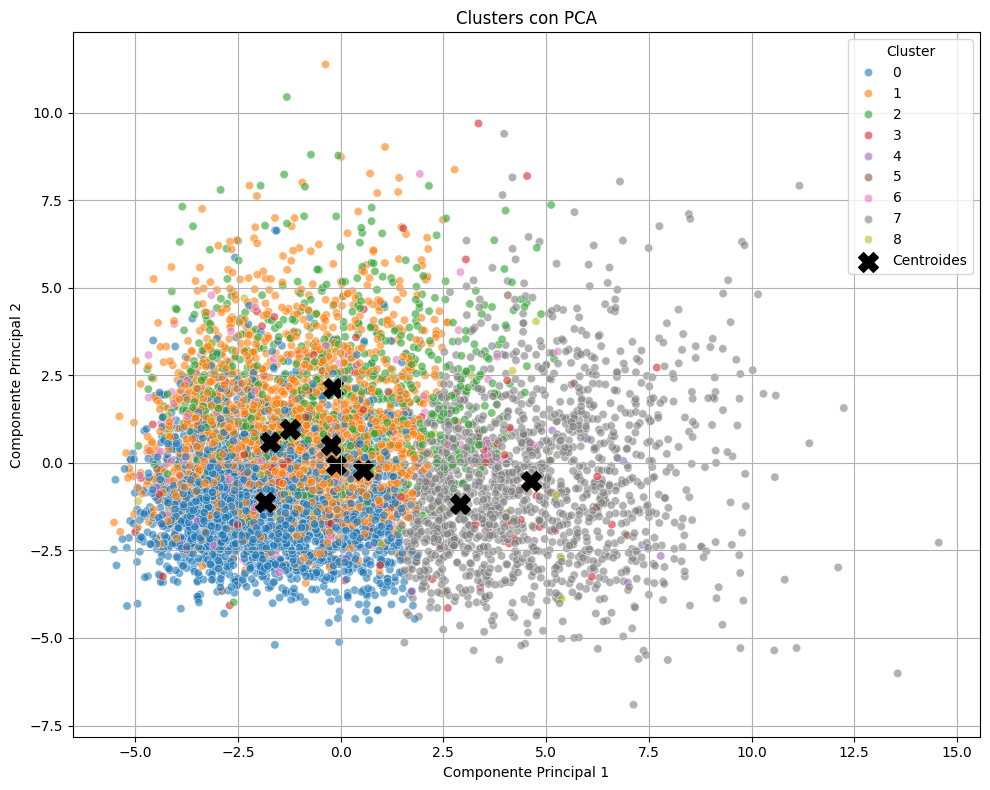

In [63]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reducir a 2 dimensiones con PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

# Transformar centroides a 2D
centroids_2d = pca.transform(kmeans.cluster_centers_)

# Añadir componentes PCA al DataFrame
df['PCA1'] = pca_components[:, 0]
df['PCA2'] = pca_components[:, 1]

# Graficar
plt.figure(figsize=(10, 8))
palette = sns.color_palette("tab10", optimal_k)

# Clusters
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='cluster', palette=palette, alpha=0.6)

# Centroides
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='black', s=200, marker='X', label='Centroides')

plt.title('Clusters con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


## ✅Conjunto de datos del Censo de Adultos

### 1. 📥 Carga del Dataset

In [64]:
# -------------------------------------
# 1. Importar librerías necesarias
# -------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# -------------------------------------
# 2. Cargar el dataset
# -------------------------------------
df = pd.read_csv("adult_tr.csv")
# df = df.sample(n=5000, random_state=42)
# Reiniciar los índices (opcional pero recomendable)
# df = df.reset_index(drop=True)
print("Dimensiones:", df.shape)
df.head()


Dimensiones: (36631, 15)


,age,workclass,final_weight,education,education-num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,threshold
0,43,Private,34278,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,35,United-States,0
1,23,Private,244698,5th-6th,3,Never-married,Farming-fishing,Other-relative,White,Male,0,0,35,Mexico,0
2,39,Private,118286,Some-college,10,Married-civ-spouse,Sales,Husband,Black,Male,0,0,40,United-States,0
3,35,Private,126675,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Male,0,0,46,?,0
4,66,Private,28367,Bachelors,13,Married-civ-spouse,Priv-house-serv,Other-relative,White,Male,0,0,99,United-States,0


### 2. 🧹 Limpieza de Datos y 📏 Escalado de Datos

In [65]:
# -------------------------------------
# 3. Preprocesamiento
# -------------------------------------

# Eliminar la columna "income" (es una etiqueta supervisada, y no la usaremos)
if 'income' in df.columns:
    df = df.drop(columns=['income'])

# Eliminar filas con valores faltantes
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)

# Separar columnas numéricas y categóricas
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

# Aplicar OneHotEncoding a categóricas y escalar numéricas
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(sparse_output=False, drop='first'), cat_cols)
])

X = preprocessor.fit_transform(df)
print("Shape después de la transformación:", X.shape)


Shape después de la transformación: (33895, 97)


### 4. 🔢 Elegir Número de Clusters (Método del Codo y Silhouette Score)

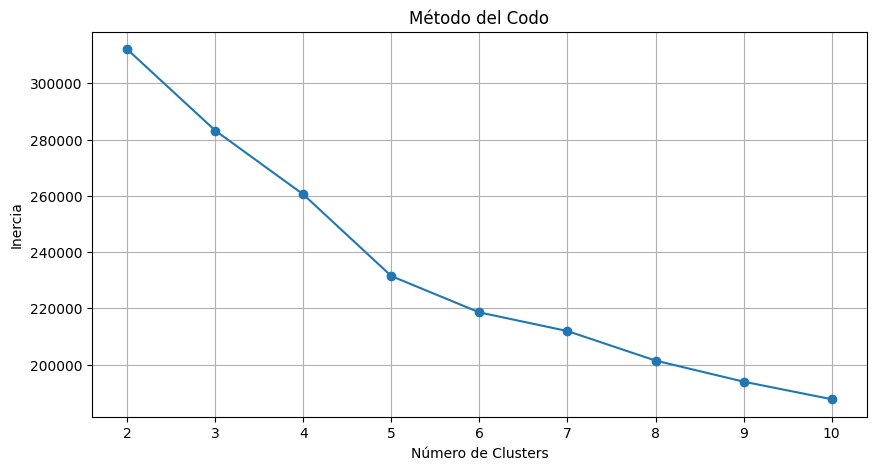

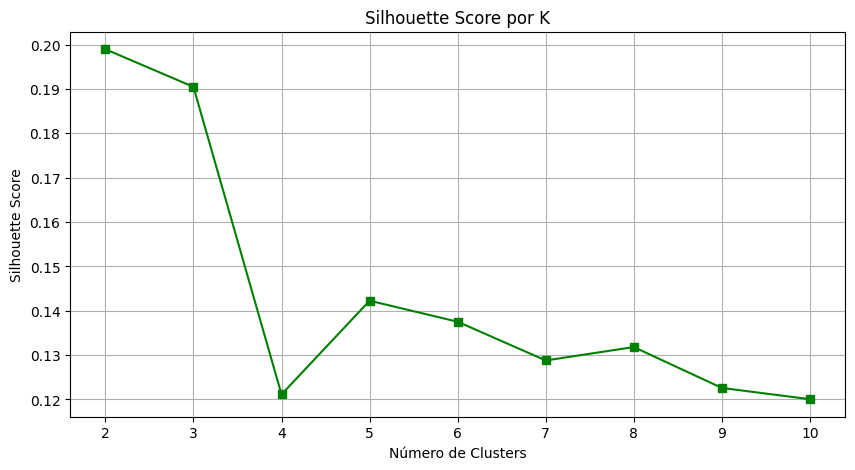

In [66]:
# -------------------------------------
# 4. Elegir el número óptimo de clusters (Codo y Silhouette)
# -------------------------------------
inertias = []
silhouette_scores = []

k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Gráfica del método del codo
plt.figure(figsize=(10, 5))
plt.plot(k_range, inertias, marker='o')
plt.title("Método del Codo")
plt.xlabel("Número de Clusters")
plt.ylabel("Inercia")
plt.grid(True)
plt.show()

# Gráfica de Silhouette Score
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, marker='s', color='green')
plt.title("Silhouette Score por K")
plt.xlabel("Número de Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


### 5. 🔀 Aplicar KMeans con el mejor K

In [70]:
# -------------------------------------
# 5. Aplicar KMeans con el mejor K
# -------------------------------------
optimal_k = 10  # Cambiar según las gráficas obtenidas
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X)

# Añadir clusters al DataFrame original
df['cluster'] = clusters
df['cluster'] = df['cluster'].astype(str)
df.head()


,age,workclass,final_weight,education,education-num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,threshold,cluster,PCA1,PCA2
0,43,Private,34278,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,35,United-States,0,0,-0.202828,0.797445
1,23,Private,244698,5th-6th,3,Never-married,Farming-fishing,Other-relative,White,Male,0,0,35,Mexico,0,6,-2.421973,0.579010
2,39,Private,118286,Some-college,10,Married-civ-spouse,Sales,Husband,Black,Male,0,0,40,United-States,0,0,-0.276483,0.404947
4,66,Private,28367,Bachelors,13,Married-civ-spouse,Priv-house-serv,Other-relative,White,Male,0,0,99,United-States,0,0,2.964779,1.575260
5,39,Private,128715,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Male,10520,0,40,United-States,1,9,1.044306,0.100854


###  6. 📊 Visualización de Clusters con PCA

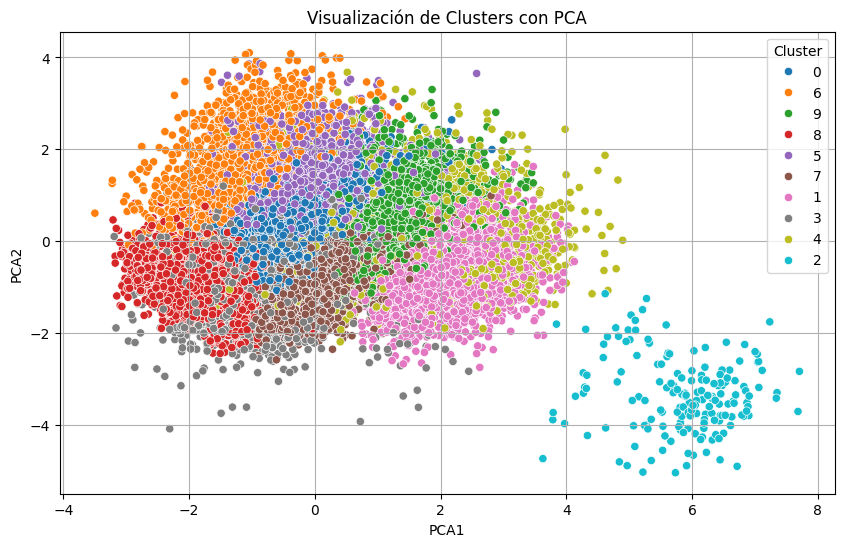

In [71]:
# -------------------------------------
# 6. Visualización con PCA
# -------------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='cluster', palette='tab10')
plt.title("Visualización de Clusters con PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [69]:
# -------------------------------------
# 7. Análisis por Cluster
# -------------------------------------
# Mostrar características promedio por cluster
cluster_summary = df.groupby('cluster')[num_cols].mean()
cluster_summary


,age,final_weight,education-num,capital_gain,capital_loss,hours_per_week,threshold
cluster,,,,,,,
0,26.665912,211361.116279,9.844701,115.736928,39.144295,36.271812,0.000780
1,43.920068,187671.742104,11.599854,1977.738095,200.247328,45.670432,0.994534
2,46.296512,186221.011628,13.058140,99999.000000,0.000000,50.761628,1.000000
3,46.997791,169768.805869,9.403092,188.141358,62.765481,42.458705,0.001657
